## Age of the oceans / depth of the oceans





In [1]:
## This is a worked example for stripy if we don't use litho1.0 information

import litho1pt0 as litho1pt0
import stripy
import numpy as np

import gdal
import cartopy
import cartopy.crs as ccrs


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
even_mesh = stripy.spherical_meshes.icosahedral_mesh(include_face_points=True, tree=True, refinement_levels=2)
number_of_mesh_points = even_mesh.npoints

In [4]:
latitudes_in_radians = even_mesh.lats
latitudes_in_degrees = np.degrees(latitudes_in_radians) 

longitudes_in_radians = even_mesh.lons 
longitudes_in_degrees = np.degrees(longitudes_in_radians)%360.0 - 180.0

In [5]:
## Obtain bathymetry information from the ETOPO1 dataset and store in numpy image format

gtiff = gdal.Open("../../../Data/Resources/ETOPO1_Ice_c_geotiff.tif")
# width = gtiff.RasterXSize
# height = gtiff.RasterYSize
# gt = gtiff.GetGeoTransform()
img = gtiff.GetRasterBand(1).ReadAsArray().T
img = np.fliplr(img)


In [6]:
## Obtain the age data and store in img format

datasize = (1801, 3601, 3)
age_data = np.empty(datasize)

ages = np.load("Data/global_age_data.3.6.z.npz")["ageData"]
ages[np.isnan(ages)] = -1000.0
ages = (np.fliplr(ages.T))


In [7]:
## Map heights to the sample grid points

def map_raster_to_mesh(mesh, raster):

    latitudes_in_radians  = mesh.lats
    longitudes_in_radians = mesh.lons 
    latitudes_in_degrees  = np.degrees(latitudes_in_radians) 
    longitudes_in_degrees = np.degrees(longitudes_in_radians)%360.0 - 180.0

    dlons = np.mod(longitudes_in_degrees+180.0, 360.0)
    dlats = np.mod(latitudes_in_degrees+90, 180.0)

    ilons = raster.shape[0] * dlons / 360.0
    ilats = raster.shape[1] * dlats / 180.0

    icoords = np.array((ilons, ilats))

    from scipy import ndimage

    mvals = ndimage.map_coordinates(raster, icoords , order=3, mode='nearest').astype(np.float)
    
    return mvals



In [8]:
meshheights = map_raster_to_mesh(even_mesh, img)
meshages    = map_raster_to_mesh(even_mesh, ages)

In [9]:
## Improve the grid to be dense in the oceans, sparse elsewhere, then remap the data


## If you refine the mesh to add new points / delete points on land etc, realise that you
## will need to re-map the data to the new mesh. Maybe add a function for the remapping

for i in range(0,3):
    nodes_to_refine = np.where(meshheights < -1000)
    allnodes = even_mesh.centroid_refine_triangulation_by_vertices(nodes_to_refine)
    even_mesh = stripy.sTriangulation(allnodes[0], allnodes[1], tree=True)
    meshheights = map_raster_to_mesh(even_mesh, img)
    meshages    = map_raster_to_mesh(even_mesh, ages)
    
    latitudes_in_radians  = even_mesh.lats
    longitudes_in_radians = even_mesh.lons 
    latitudes_in_degrees  = np.degrees(latitudes_in_radians) 
    longitudes_in_degrees = np.degrees(longitudes_in_radians)%360.0 - 180.0

In [10]:
## Now delete points on land etc

valid = (meshages>0) & (meshages<180) & (meshheights<0.0)
ocean_mesh = stripy.sTriangulation(even_mesh.lons[valid], even_mesh.lats[valid], tree=True)
    
meshheights = map_raster_to_mesh(ocean_mesh, img)
meshages    = map_raster_to_mesh(ocean_mesh, ages)
  
latitudes_in_radians  = ocean_mesh.lats
longitudes_in_radians = ocean_mesh.lons 
latitudes_in_degrees  = np.degrees(latitudes_in_radians) 
longitudes_in_degrees = np.degrees(longitudes_in_radians)%360.0 - 180.0

In [47]:
## Smooth mesh heights

meshweights = (meshheights > 0.0) * 1.0 + 0.1

# Smoothing 
smeshheights, sdx = ocean_mesh.smoothing(meshheights, meshweights, 1.0e8, 0.25, 0.0001)

# This is not as smooth
# smeshheights, sdx = ocean_mesh.smoothing(meshheights, meshweights, 1.0e7, 0.25, 0.0001)

# This is also not as smooth
# smeshheights, sdx = ocean_mesh.smoothing(meshheights, meshweights, 1.0e8, 0.75, 0.0001)



print("Raw bathymetry min / max: {}/{}".format(meshheights.min(), meshheights.max()))
print("Smoothed min / max: {}/{}".format(smeshheights.min(), smeshheights.max()))

Raw bathymetry min / max: -8148.0/-16.0
Smoothed min / max: -6708.70458984375/-199.8422393798828


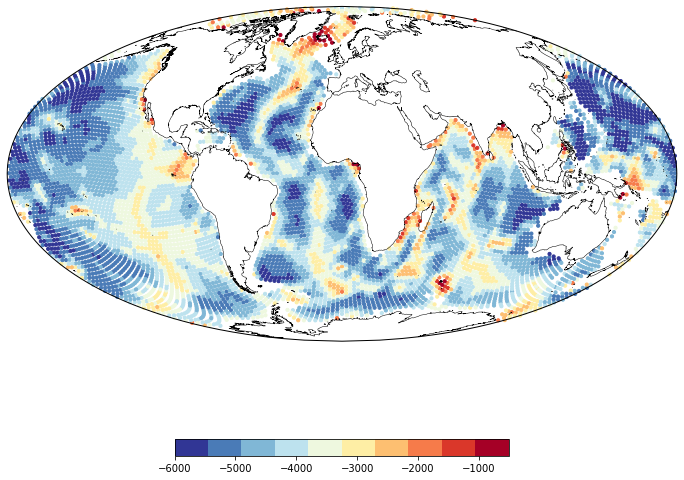

In [49]:
## Is that sensible ?

## Check the age / bathymetry / smoothed bathymetry by eye

%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

global_extent     = [-180.0, 180.0, -89, 89]

projection0 = ccrs.PlateCarree()
projection1 = ccrs.Orthographic(central_longitude=140.0, central_latitude=0.0, globe=None)
projection2 = ccrs.Mollweide()
projection3 = ccrs.Robinson()

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111, projection=projection2)
ax.set_global()

colormap = plt.cm.get_cmap('RdYlBu_r', 10)

# m = ax.scatter(longitudes_in_degrees, latitudes_in_degrees, 
#                c=meshages, cmap=colormap, vmin=0.0, vmax=180.0,
#                s=10.0, transform=ccrs.Geodetic())

m = ax.scatter(longitudes_in_degrees, latitudes_in_degrees, 
               c=smeshheights, cmap=colormap, vmin=-6000, vmax=-500.0,
               s=10.0, transform=ccrs.Geodetic())



plt.colorbar(mappable=m, orientation="horizontal", shrink=0.5)
ax.coastlines(resolution="50m", zorder=100, linewidth=0.5)


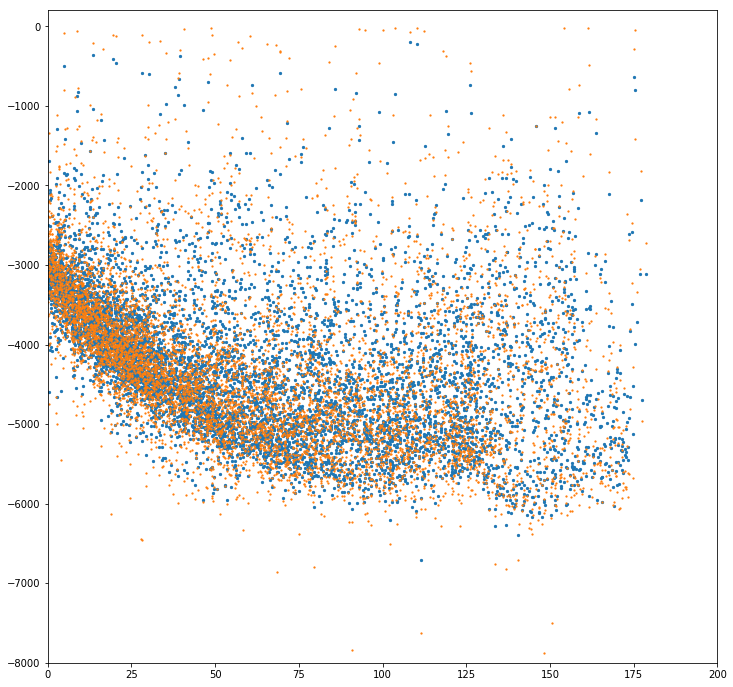

In [52]:
fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111)
ax.scatter(meshages, smeshheights,s=5.0)
ax.scatter(meshages, meshheights,s=1.5)
ax.set_xlim([0.0,200.0])
ax.set_ylim([-8000.0,200.0])
pass

In [63]:
## Use scipy optimize to fit this data to  h = a + sqrt(b * age)

from scipy import optimize

def depth_age_fn(age, p1, p2):
    return p1 + p2 * np.sqrt(age)


print("Curve fit")
valid = (meshages>0) & (meshages<70) & (meshheights<0.0)
popt, pcov = optimize.curve_fit(depth_age_fn, meshages[valid], meshheights[valid] )
print("Curve fit for smoothed values")
valid = (meshages>0) & (meshages<70) & (meshheights<0.0)
popts, pcovs = optimize.curve_fit(depth_age_fn, meshages[valid], smeshheights[valid], method="lm" )


Curve fit
Curve fit for smoothed values


In [64]:
ages = np.linspace(0.0,150.0, 100)
depths = depth_age_fn(ages, popt[0],popt[1])
depthss = depth_age_fn(ages, popts[0],popts[1])


(-8000.0, 200.0)

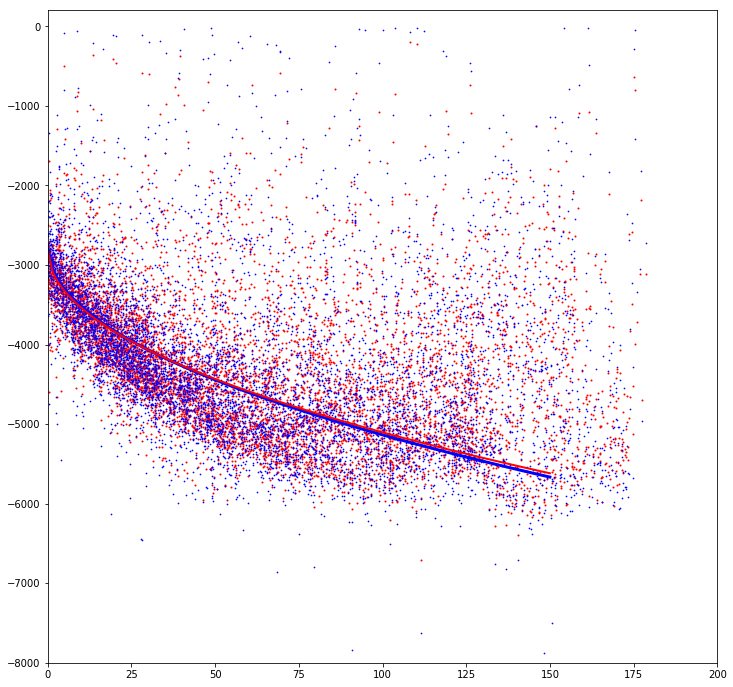

In [65]:
fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111)
ax.scatter(meshages, smeshheights,s=1.0, c="Red")
ax.scatter(meshages, meshheights,s=0.5, c="Blue")
ax.plot(ages, depths, linewidth=3.0, c="Blue")
ax.plot(ages, depthss, linewidth=2.0, c="Red")
ax.set_xlim([0.0,200.0])
ax.set_ylim([-8000.0,200.0])